(1001, 6) (6, 1001)
(1001, 6) (6, 1001)


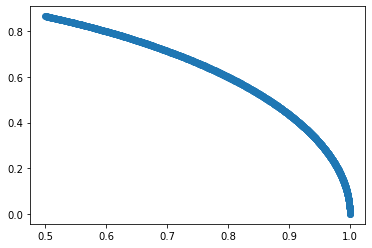

In [141]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin
import quadrotor
import math



robot = quadrotor.Quadrotor()
horizon_length = 1000
N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10


x_desired = [math.cos(o*(T/N)*i) for i in range(0,N+1)]
y_desired = [r*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vx_desired = [-r*o*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vy_desired = [ r*o*math.cos(o*(T/N)*i) for i in range(0,N+1)]
theta_desried = [0 for i in range(0,N+1)]
omega_desried = [0 for i in range(0,N+1)]

# v = 1/10
# v= v
# x_desired = [v*i*T/(N) for i in range(0,N+1)]
# y_desired = [v*i*T/(N) for i in range(0,N+1)]
# vx_desired = [v for i in range(0,N+1)]
# vy_desired = [v for i in range(0,N+1)]
# theta_desried = [0 for i in range(0,N+1)]
# omega_desried = [0 for i in range(0,N+1)]



state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
ref_traj = state_desired.T
print(ref_traj.shape,state_desired.shape)




# x=np.linspace(0,2*math.pi,horizon_length+1)
# z_bar=np.zeros([6,horizon_length+1])
# z_bar[0,:]=np.cos(x)
# z_bar[1,:]=-np.sin(x)
# z_bar[2,:]=np.sin(x)
# z_bar[3,:]=np.cos(x)
# ref_traj = z_bar.T
# state_desired = z_bar




z0 = np.zeros_like(state_desired[:,0])
u_init = [(robot.mass * robot.g / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)

plt.figure()
plt.scatter(x_desired,y_desired)

plt.show()




In [142]:
import pylqr
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np



class LQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.lqr_ = None

        self.use_autograd=use_autograd
        return

    def build_LQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x[0:self.obj.nu] - self.ref_array[t]
            #autograd does not allow A.dot(B)
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.lqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                  use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:obj.next_state(x,u,t)
            self.plant_dyn_du_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((self.obj.ns,self.obj.ns))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(self.obj.nu)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((self.obj.nu,self.obj.ns))

            # build an iLQR solver based on given functions...
            self.lqr_.plant_dyn = self.plant_dyn
            self.lqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.lqr_.plant_dyn_du = self.plant_dyn_du_
            self.lqr_.cost_dx = self.cost_dx_
            self.lqr_.cost_du = self.cost_du_
            self.lqr_.cost_dxx = self.cost_dxx_
            self.lqr_.cost_duu = self.cost_duu_
            self.lqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.lqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.lqr_.LQR_solve(x_init,u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:self.obj.nu]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.lqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(i,self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.lqr_.LQR_solve(x_init,u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        return Ks,ks

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = self.obj.next_state(x_new_array[t], u_new_array[t], t)
        return np.array(x_new_array), np.array(u_new_array)


In [152]:
ref_traj.shape

(1001, 6)

In [155]:
weight_mats = [np.diag([1,1,1,1,0,0]) * 100]
lqr_traj_ctrl = LQR_Track_Controller(R=.01, dt=0.01)
lqr_traj_ctrl.build_LQR_tracking(ref_traj, weight_mats, robot)
x0 = ref_traj[0, :]
Ks,ks = lqr_traj_ctrl.get_rule(x0,u_init)

def lqr_controller(state,i):
    ut = Ks[i].dot(state-state_desired[:,i]) + ks[i] + u_init[i]
    return ut.T


t, state, u = robot.simulate(z0,lqr_controller, horizon_length, disturbance = False)



<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAQDBtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3iZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZRvsR0TaOEO5b8o0ujSeIOIgkhOahi4LpV4bVwK7he/ZWo2EuAlsgT8wA30ZbL
wxWrckoxjTmGltHrkOT94ux0DHMECvahXEYWRP8+EZ9m2FtbGM87U5PlU64eUabBTV3Wnsn0B/2R
juUaQEeRisjjK6w9xhThdeSIEFeZ92nFAAADALUJmMzIrlzbZgF1CUqCXUqRwKxHFQu+PTuUm9oT
/Vy3SzoQFPDMT5Ra6nIZNf287fjlo2z/A1D/hXVu69U4jR1B5LgHGGFfma/S8zYm00FY9HJpLUQI
o8vr8x2jOojPA/pyd34cdKKxgRl4bSAipTKY9OevUjE/+kGCaCbwEVK1ZNMeMszFDrRxiXUrh7Wb
eELWicEcHDHF9aCFrlQXQgwzuRotpH7hqg8AMClCEjNHTuf1cVlp78zbFX18BWbBnDYyKYYb6z4D
I7n28etNoeKwPu74SQDdSX/pUDTBJBfj2EmBdn9b2VbHKwoW3v1fsf/IB9Mj+RHjncVs2n/eBSdI
h722W1f5o8sL81veZGuPhq5wASq+uqgE0ObE3GwbvTfiEsB9UOc6hh730UjzDKDn0jzyLNtDBd2O
E+FVybY2xQxxxO8n4/MCdqNJXazQzsYeRGkp//3JyKJ2Z3XOU7rGEL7WDj3EoWgHx/Hd/a0LgZxD
ZuyW8Wgd76WoAZ1zcU5UX8dN46rkEQoEmqsEII41LsLOv07oEFOMAdkwgRRu3gyv/nyBvsQi8bSj
ZZMI/Q/r6/rUxAxG7wfYnXc1Fz6jevpwVGRGvasXVxTX6lpUa0QWhAU0kSDqdEaES+OCltA1Zjms
tdGr40gHk8owgTf2b97LrZJKpd70/rIVMzs6+KINO3aBmmfJI3LMbDVom+nlgpB8xa0qxTaaDyua
rgy6yf2tXHoCkAAAAwAAZI6NH8byRJ4tLmmZju/uxroYbxs7M+h+krmuM25uhBpJwq6bkEj2dzr3
rHAVwzmAN79u5gS2HXovMmdOtsbYs4aQ222SjsIkMjpGFibyyBpbzrAfslbeQBuKcGVQ7L0TAxFS
aAkDaxTzhrr3/ppfUA1qWIKFUtaeUkjTR/+2ymje7rV1dktcspbvIICUo7tTj2uDTAoNU7O9Zf0K
CqUnUB855OqCtEw0JACUiOMhiFQRMRlsiWoLgdriZfKD8RTXMXu/voBOQSH2m3+NRja0nKWk+UFe
gMJb0XEt+A0z/45oPG4RaWA61k4G+yQu0ugNc4yU9+AzMOrXWoG2IaE+r3q3jjakTdsdPD6IPBct
euD0odsrSGiidugif1YRrzc2GEkwLbfk2c17b+Gg/7lvFtfTRd+5ARNyh4iY/CvPDs2rLkOhXaob
Yq0gkCjEwCutnzHNiZp0pJM+r5XtBf2rU8JlRH+Cl+L0Qv//2GhnyFfHLwsxLP5+qBvIZyOiP9sf
n3LLGIsBEKPGTAjAecJ+i7Al3V3Gg2mKLx3/xMqoAibmBc3xCEmy//tCdUe1qbzYx57Z59ImmMTA
dKMYRgiyLLlErBDVksY02UYBwHruI3SZUszTwKAswKtExwVpIWZE49pi0wPkRBkJOJDDRNdmSE0L
Gj3C2zpq8FUS2AAEVAAA5uIixmX527UpuBL0ErkC+ZQTfm//7gJSOGXOESbU4Ot9iWeue7YVfPxH
UvokwAtSTJtrDF1vJ3c5UPFxejcthXtdO78F0z/DPBcDshSb7mp8NoNTu166060eIhsmaK9Vy5e9
RDFrpF1zNOE9liYQu6Zd6iVu2OqdVAdzCpi41A9ZMzkpEMaZ//1qhZ3hYODtcyfnVdvYaX5S/94u
WlZ//Y+sm3MHqlCcmOHl3dEknekZipJEu9Lhf5MMSb3hZShskhaNdh1AvnS3ldhFpLAYHj0YxCLp
mgEQ1mgt2nlpbY5/+sDjyMYT2/2fXS4ReZJloyP5zbv+9/k+oZaOGBkP9OzMco2MVSQAvXNpo4OH
j2mqQ4IZhggE5yU67gSqK7g2l8KgV8lArmAY/3mqJ+7xvoL0oN/2Bw87Gc+ugEk4paaChLmqJ7jt
iTHL8nyUFH8gq9V8kfdTsz/JMqIDQwMDMQ3WltDprzrzL/JX6DEBia+1qrl4rgwoH5tMQnXo/h4+
57hvK54cdoL6AAjEtdx4GKSTPq+d2XgLEtk9pMcQyUWMLb/3/pdnCcwjsFBU1vqYJ79UDeQzkdEK
kIcQi5Vf6P7DDto4q2dSWGA84TuoC3XtbTcvD+Dx7fUwgbTB/od4k8TrT/QCRjHAWhDCi+BbqOBq
gBhOa69E6T0To0S0UYVfg

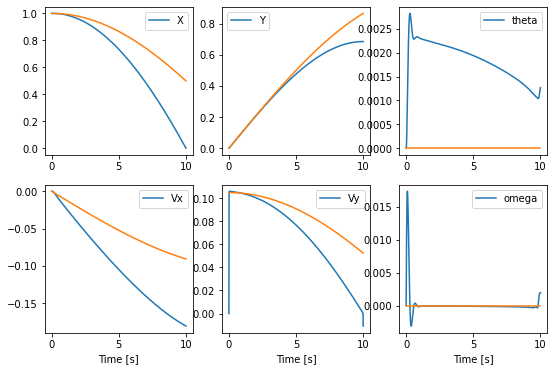

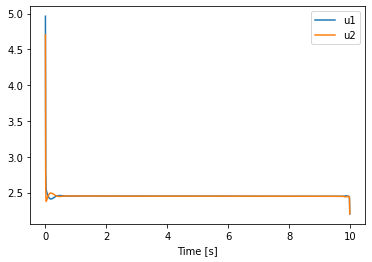

In [156]:

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
robot.animate_robot(state,u)